# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [1]:
%pip install -q moviepy --upgrade
%pip install -q ffmpeg --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("/content/data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
video.fps

23.976023976023978

In [4]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


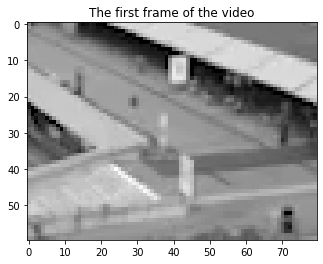

In [5]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

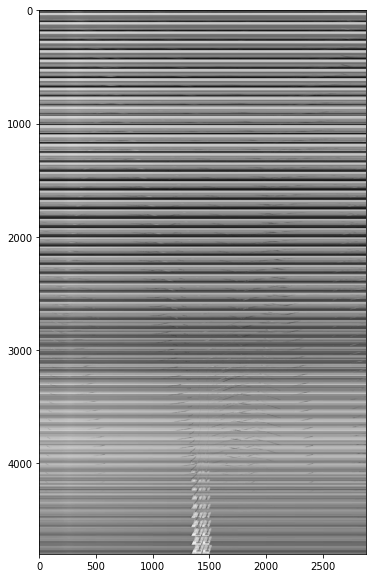

In [6]:
nframes, size_w, size_h = arr.shape
M = arr.reshape((nframes,size_w*size_h)).T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

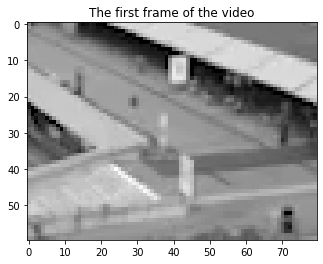

In [7]:
first_frame = M[:,0].reshape((size_w,size_h)) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [8]:
U,S,Vh=np.linalg.svd(M,full_matrices=False)

Text(0, 0.5, 'value')

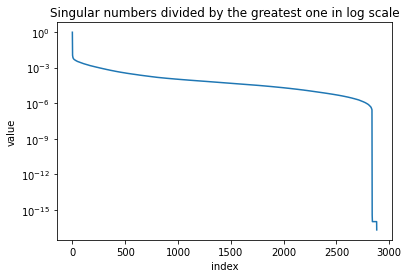

In [9]:
plt.semilogy(S/S[0])
plt.title("Singular numbers divided by the greatest one in log scale")
plt.xlabel("index")
plt.ylabel("value")

-----------------------------------------------------------------
объяснение: наибольшие сингулярные числа выделяются, потому что формально на них и держится кадр(картинка), то есть если их убрать, кадр прервратится в мыльное мыло; наибольшие сингулярные числа выделяются, наверное потому что слишком близки к нулю, а-ля стремление к машинному эпсилону
----------------------------------------------------------------

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [50]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    Sr = S.copy()
    Sr[r:] = 0
    Mr = U @ np.diag(Sr) @ Vh
    rel_eps = np.linalg.norm(np.diag(S - Sr)) / np.linalg.norm(np.diag(S))
    return Mr, rel_eps

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [51]:
M_svd, rel_eps1 = trunc_svd(M, 1)
rel_eps1

0.05566854476973748

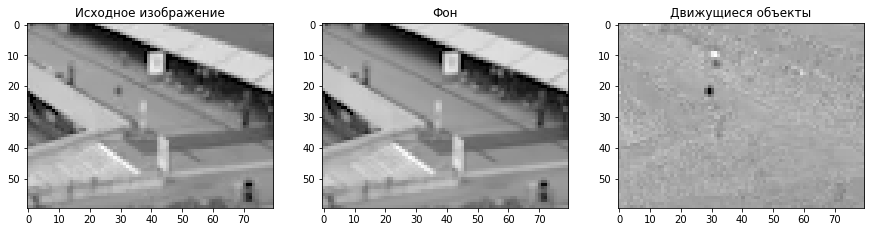

In [12]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_svd[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M - M_svd)[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [13]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("/content/data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [16]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = arr3.reshape((nframes,size_w*size_h)).T

image size: 100 x 178, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [29]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    O = np.random.randn(M.shape[1], r + oversampling)
    Y = M @ O
    Q = np.linalg.qr(Y)[0]
    W, S, Vh = np.linalg.svd(Q.T @ M, full_matrices=False)
    Sr = S.copy()
    Sr[r:] = 0
    Mr = (Q @ W) @ np.diag(Sr) @ Vh
    # Mr = (Q @ W[:, :r]) @ np.diag(S[:r]) @ Vh[:r, :]
    rel_eps = np.linalg.norm(M - Mr) / np.linalg.norm(M)
    return Mr, rel_eps

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [53]:
M_rand, rel_eps2 = rand_svd(M3, 1)
rel_eps2

0.04825708306518774

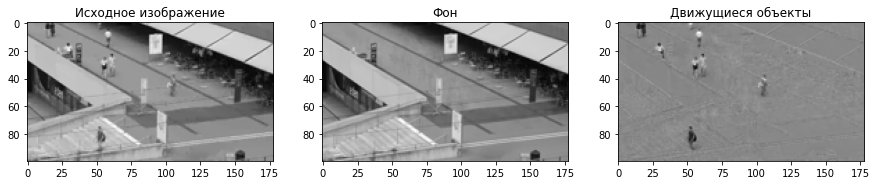

In [31]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M3[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_rand[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M3 - M_rand)[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

In [32]:
p_list = np.arange(0, 32, 2)
res = []
for p in p_list:
    M_rand_p = np.zeros(M3.shape)
    for _ in range(10):
        M_rand_p += rand_svd(M3, 2, p)[0]
    M_rand_p /= 10
    res.append(np.linalg.norm(M_rand_p - M3) / np.linalg.norm(M3))

Text(0.5, 0, 'p')

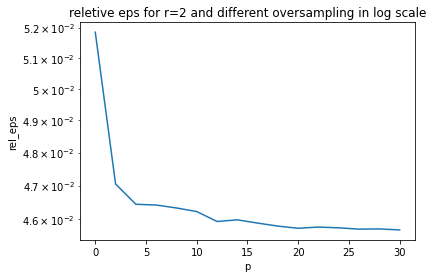

In [33]:
plt.semilogy(p_list, res)
plt.title("reletive eps for r=2 and different oversampling in log scale")
plt.ylabel("rel_eps")
plt.xlabel("p")

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [34]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [35]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [36]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

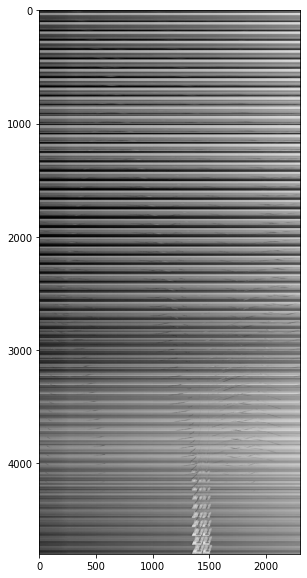

In [37]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape((nframes2, size_w * size_h)).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [38]:
import time
st = time.time()
M2_svd, rel_eps_svd = trunc_svd(M2, 2)
print("Numpy SVD:", time.time() - st)
st = time.time()
M2_rand, rel_eps_rand = rand_svd(M2, 2)
print("Randomized SVD:", time.time() - st)

Numpy SVD: 25.43980383872986
Randomized SVD: 0.4248979091644287


3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [58]:
rel_eps_trunc3 = trunc_svd(M3, 2)[1]
rel_eps_rand3 = rand_svd(M3, 2)[1]
rel_eps_trunc2 = trunc_svd(M2, 2)[1]
rel_eps_rand2 = rand_svd(M2, 2)[1]

In [73]:
print("Numpy SVD: constant lighting --", rel_eps_trunc3,"variable lighting --", rel_eps_trunc2)
print("Randomized SVD: constant lighting --",rel_eps_rand3, "variable lighting --", rel_eps_rand2)

Numpy SVD: constant lighting -- 0.045553649205798616 variable lighting -- 0.060632330984504774
Randomized SVD: constant lighting -- 0.05039253840986354 variable lighting -- 0.06319365882144794


---------------------------------------------
выводы: из относительной точности видим, что библиотечная функция приближает с большей точность как при постоянном освещении, так и при переменном, нежели рандомизированный алгоритм; также убедились, что при постоянном освещении можно точнее приблизить матрицу, тем самым точнее отделить фон от движущихся объектов, чем при переменном.
----

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [60]:
def M_to_video(M, fps, size_w, size_h):
    print(M.shape)
    nframes = M.shape[1]
    arr = M.T.reshape((nframes, size_w, size_h))
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [61]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

(4800, 2306)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

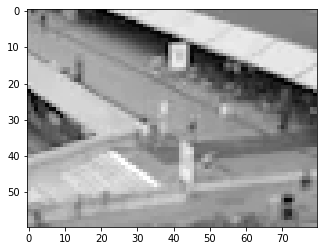

In [62]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [66]:
def trunc_svd_usv(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    return U[:,:r], np.diag(S[:r]), Vh[:r,:]


U_2, S_2, VT_2 = trunc_svd_usv(M2, 2)

In [67]:
def project_new_frames(U, S, VT, new_frames):
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    return U @ (U.T @ new_frames)

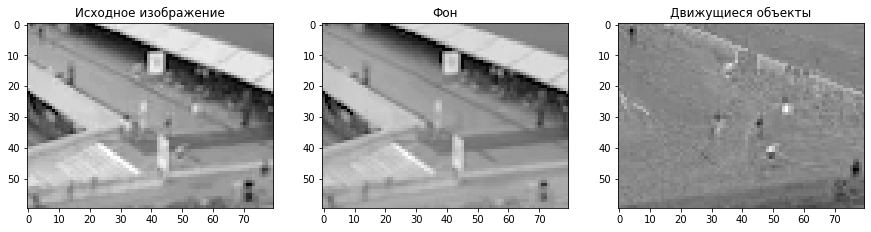

In [68]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((new_frame - new_frame_proj).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [75]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape((remaining_nframes, size_w * size_h)).T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [76]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

(4800, 2883)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [77]:
def rand_svd_usv(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    O = np.random.randn(M.shape[1], r + oversampling)
    Y = M @ O
    Q = np.linalg.qr(Y)[0]
    W, S, Vh = np.linalg.svd(Q.T @ M, full_matrices=False)
    return (Q @ W)[:,:r], np.diag(S[:r]), Vh[:r,:]


U_2_rand, S_2_rand, VT_2_rand = rand_svd_usv(M2, 2)

In [78]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

(4800, 2883)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [79]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

(4800, 2883)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [81]:
print("relative eps M_proj:", np.linalg.norm(M_true - M_proj) / np.linalg.norm(M_true))
print("relative eps M_proj_rand:", np.linalg.norm(M_true - M_proj_rand) / np.linalg.norm(M_true))

relative eps M_proj: 0.020001445065678095
relative eps M_proj_rand: 0.028182976793877955


**Выводы:**

В ходе выполнения данного ПДЗ я познакомился с одним из приложений сингулярного разложения --- разложения кадров видео на фон и движущиеся объекты, а так же удаления фона с видео. Я поэксперементировал с разными качествами и освещениями в предложенных видое. Для этого сначала я воспользовался  SVD разложением, реализованным в библиотеке NumPy. Плюсом этого способа является точность, а к минусу можно отнести долгое время работы на больших матрицах. Поэтому далее я попробывал заменить библиотечное SVD простейшим рандомизированный алгоритмом. Огромным плюсом этого разложения является скорость: в пункте С2 я сравнил время работы двух этих алгоритмов и получил, что рандомизированный работает в 60 раз быстрее(понятно, что это очень грубо, ведь там мы ещё ищем относительную точность, причём в одном случае с лишь с помощью сингулярных чисел, а в другом случае разложение никак не используется). В плане точности оно незначительно, но проигрывает библиотечному SVD.

По поводу сравнения качеств видео(последние три видео, буду обращаться к ним по порядку): сравнивая первое и второе видео, разница особо не видна, имхо на первом люди чуть ярче и чётче, но хз, может я просто это внушил себе; третье же видео менее подвержено переменности освещения --- это можно понять по херне в правому верхнем углу(а-ля настил), типа он не движется, и в первых двух видео он появляется при улучшение освещения, а в последнем неизменно невиден(разве что в конце самую малость).

По итоговым ошибкам: видно, что они в ~ 2 раза меньше, чем в прошлых пунктах, что соответствует предположению. Ну и опять же, библиотечное SVD ебёт рандомизированное.

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [ ]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [ ]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)

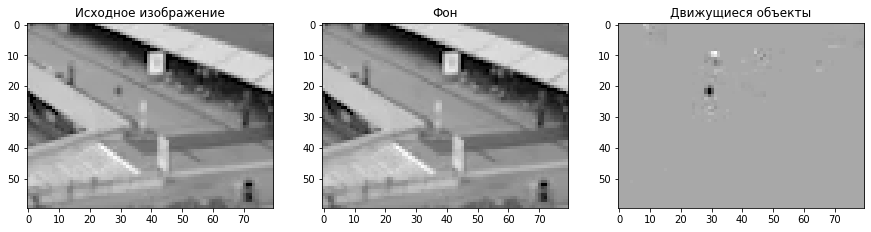

In [ ]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(Mt[:, 0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:, 0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(S[:, 0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [ ]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

(4800, 360)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.